In [34]:
import os
import re
import nltk
import string
import pandas as pd
import multiprocessing
from string import digits
from textblob import TextBlob
from nltk import word_tokenize
import matplotlib.pyplot as plt
from autocorrect import Speller
from nltk.corpus import wordnet
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [35]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download("words")
# nltk.download("stopwords")

In [36]:
def get_files(path):
    return os.listdir(path)

In [37]:
def clean(word):
    word2 = word.translate(re.sub(r'\d+', '', word).maketrans('', '', string.punctuation)).lower()
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

In [38]:

delete_words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in delete_words or not w.isalpha())

In [39]:
def isValid(word):
    if len(word) == 2 and word[1] == 'a':
        return False
    return True

In [40]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [41]:
spell = Speller(lang='en')
def clear_document(sentences):
    new_words = ''
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    for sentence in sentences:
        new_words += sentence.strip()
    new_words = clean(new_words)# regexp stemmer (puctuation cleaning)
    tokinezed = word_tokenize(new_words) #tokenization
    tags = nltk.pos_tag(tokinezed) #pos tagging
    correct_sentence = []
    for i in tags:
        position = get_wordnet_pos(i[1])
        if position == '':
            correct_sentence.append(lemmatizer.lemmatize(word=i[0]))  # lemmatization
        else:
            correct_sentence.append(lemmatizer.lemmatize(word=i[0], pos=position))  # lemmatization 
    correct_sentence = [lemmatizer.lemmatize(i) for i in correct_sentence]
    correct_sentence = [spell(i) for i in correct_sentence]
    stop_words = []
    stops = stopwords.words('english') #stop word removal
    [stop_words.append(word.replace("'", '') ) for word in stops]
    stop_words = list(set(stop_words))
    filtered_words = list(map(clean_sent, correct_sentence))
    filtered_words = [word for word in filtered_words if word not in stops and isValid(word)]
    while(True):
        if '' in filtered_words:
            filtered_words.remove('')
        else:
            break
    return ' '.join(filtered_words)

In [42]:
def clean_document(fileName):
    with open(fileName[0]) as f:
        words = f.readlines()
        cleaned_document = clear_document(words)
    with open(fileName[1],"w") as f:
        f.write(cleaned_document)

In [43]:
path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
for i in range(2):
    path = path_list[i]
    path_2 = path_list_2[i]
    files = get_files(path)
    filenames = [(path + file, path_2+file) for file in files]
    with multiprocessing.Pool(20) as p:
        # Use the pool to read all the files in parallel
        p.map(clean_document, filenames)

In [44]:
path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
all_documents = []
sentiments = []
for i in range(2):
    path = path_list_2[i]
    files = get_files(path)
    for file in files:
        with open(path+file) as f:
            sentence = f.readline()
        all_documents.append(sentence)
        sentiments.append(path[-4:-1])

In [45]:
df = pd.DataFrame(columns=['text'], data=all_documents)

In [46]:
df['number_of_words'] = df['text'].apply(lambda x : len(TextBlob(str(x)).words))
df['polarity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.subjectivity)
df['number_of_letters'] = df['text'].apply(lambda x: sum([len(i) for i in x.split(' ')]))

In [47]:
df

,text,number_of_words,polarity,subjectivity,number_of_letters
0,assume nothing phrase perhaps one used first i...,376,0.167592,0.647744,2038
1,plot male model also dumb impressionable reaso...,286,0.025651,0.559099,1601
2,actually fan original flick name star mill twi...,717,0.189720,0.537842,3945
3,movie thats highly build human show review boa...,184,0.064375,0.360104,970
4,good hunt two movie one independent take strug...,145,0.207433,0.499777,909
...,...,...,...,...,...
1995,synopsis meteorite desert community college pr...,137,0.119066,0.555123,878
1996,anniversary slaying love best friend still bes...,252,0.148363,0.598198,1400
1997,coincide emerge popularity movie deal anything...,155,0.014219,0.464103,935
1998,highflying hong style make way classic pretty ...,209,-0.047128,0.451001,1202


In [48]:
bag_of_words_model = CountVectorizer(max_features=10)

In [49]:
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
bag_of_word_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,6,2,1,3,2,0,2,1,6,3
1,2,6,3,1,0,4,1,4,1,4
2,1,18,2,2,5,7,7,4,12,7
3,1,4,1,3,2,0,1,6,0,1
4,1,2,0,0,5,2,1,1,1,0


In [50]:
tfidf_model = TfidfVectorizer(max_features=10)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(all_documents).todense())
tfidf_df.columns = tfidf_model.get_feature_names_out()
tfidf_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,0.620535,0.171225,0.101604,0.320219,0.217368,0.000000,0.191307,0.092488,0.523057,0.326748
1,0.216574,0.537834,0.319149,0.111760,0.000000,0.415934,0.100153,0.387354,0.091276,0.456156
2,0.044053,0.656394,0.086556,0.090931,0.231469,0.296113,0.285204,0.157581,0.445590,0.324748
3,0.131662,0.435953,0.129347,0.407652,0.276720,0.000000,0.121771,0.706450,0.000000,0.138655
4,0.163510,0.270704,0.000000,0.000000,0.859143,0.314024,0.151228,0.146223,0.137825,0.000000


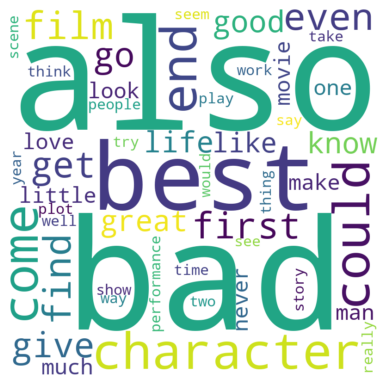

In [51]:
tfidf_model = TfidfVectorizer(max_features=50)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(all_documents).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
bests1= list(tfidf_df.columns)
wordcloud = WordCloud(width = 800, height = 800, 
    background_color ='white', 
    max_words=200,
    stopwords = [],
    min_font_size = 10).generate(' '.join(bests1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

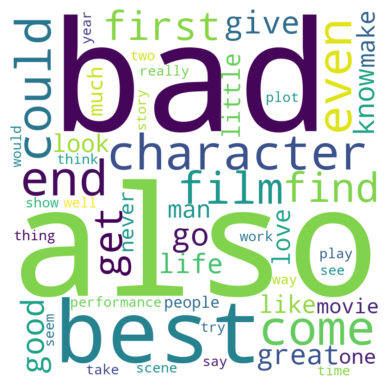

In [52]:
bag_of_words_model = CountVectorizer(max_features=50)
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = bag_of_words_model.get_feature_names_out()
bests2= list(bag_of_word_df.columns)
wordcloud = WordCloud(width = 800, height = 800, 
    background_color ='white', 
    max_words=50,
    stopwords = [],
    min_font_size = 10).generate(' '.join(bests2))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
bests1 == bests2

True

In [54]:
df['text'][0]

'assume nothing phrase perhaps one used first impression rumor hardly ever seem phrase especially go nova architect main focus three tango delightful funny romantic comedy assumption nova perry shy clumsy base architect along openly gay partner peter plant fight project day day one job restore popular building rich businessman immediately take liking enjoy personality sense humor see someone could trust ask watch unpredictable adventurous girl name amy post never make living blow glass want know talk go point make sure see someone else course gladly take job meet amy art show spark fly two get go feel find one meant content idea amy well another popular phrase good thing must come end stay true well walk amy drink one night amy become great friend doesnt seem mind think gay afraid share either stand shock word swear gay id kill matter flamboyant mouth word spread instantly town come supposed madness tell everyone one would immediately think would deny fact numerous occurrence come resu

In [55]:
lemmatizer = WordNetLemmatizer()
for i in df['text'][0].split(' '):
    print(lemmatizer.lemmatize(i))

assume
nothing
phrase
perhaps
one
used
first
impression
rumor
hardly
ever
seem
phrase
especially
go
nova
architect
main
focus
three
tango
delightful
funny
romantic
comedy
assumption
nova
perry
shy
clumsy
base
architect
along
openly
gay
partner
peter
plant
fight
project
day
day
one
job
restore
popular
building
rich
businessman
immediately
take
liking
enjoy
personality
sense
humor
see
someone
could
trust
ask
watch
unpredictable
adventurous
girl
name
amy
post
never
make
living
blow
glass
want
know
talk
go
point
make
sure
see
someone
else
course
gladly
take
job
meet
amy
art
show
spark
fly
two
get
go
feel
find
one
meant
content
idea
amy
well
another
popular
phrase
good
thing
must
come
end
stay
true
well
walk
amy
drink
one
night
amy
become
great
friend
doesnt
seem
mind
think
gay
afraid
share
either
stand
shock
word
swear
gay
id
kill
matter
flamboyant
mouth
word
spread
instantly
town
come
supposed
madness
tell
everyone
one
would
immediately
think
would
deny
fact
numerous
occurrence
come
resul

In [56]:

porter = PorterStemmer()
spell = Speller(lang='en')
for i in df['text'][0].split(' '):
    stemmed = porter.stem(i)
    print(spell(i))

assume
nothing
phrase
perhaps
one
used
first
impression
rumor
hardly
ever
seem
phrase
especially
go
nova
architect
main
focus
three
tango
delightful
funny
romantic
comedy
assumption
nova
perry
shy
clumsy
base
architect
along
openly
gay
partner
peter
plant
fight
project
day
day
one
job
restore
popular
building
rich
businessman
immediately
take
liking
enjoy
personality
sense
humor
see
someone
could
trust
ask
watch
unpredictable
adventurous
girl
name
amy
post
never
make
living
blow
glass
want
know
talk
go
point
make
sure
see
someone
else
course
gladly
take
job
meet
amy
art
show
spark
fly
two
get
go
feel
find
one
meant
content
idea
amy
well
another
popular
phrase
good
thing
must
come
end
stay
true
well
walk
amy
drink
one
night
amy
become
great
friend
doesnt
seem
mind
think
gay
afraid
share
either
stand
shock
word
swear
gay
id
kill
matter
flamboyant
mouth
word
spread
instantly
town
come
supposed
madness
tell
everyone
one
would
immediately
think
would
deny
fact
numerous
occurrence
come
resul

In [57]:
lemmatizer.lemmatize('working','v')

'work'

In [58]:
spell(porter.stem('anything'))

'any'

In [59]:
porter.stem('anything')

'anyth'

In [60]:
stops = stopwords.words('english') #stop word removal
#stops.append(word.replace("'", '') for word in stops) 
#stop_words = set(stops)

In [61]:
a = nltk.pos_tag(['I', 'am', 'a', 'man'])

In [62]:
for i in a:
    print(i[0], i[1])

I PRP
am VBP
a DT
man NN


In [63]:
path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
path = path_list[0]
files = get_files(path)
with open(path+files[0]) as f:
    words = f.readlines()
cleaned_document = clear_document(words)